In [1]:
import cv2
import pandas as pd
import random
import os 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns

In [2]:
data_path = "data\\chest_xray"
train_path = os.path.join(data_path, "train")
train_path_normal = os.path.join(data_path, "train\\NORMAL")
train_path_pneumonia = os.path.join(data_path, "train\\PNEUMONIA")
test_path = os.path.join(data_path, "test")
val_path = os.path.join(data_path, "val")


## EDA (Exploratory Data Analysis)

In [3]:
for dataset_type in ["train", "test", "val"]:
    for category in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(data_path, dataset_type, category)
        print(f"{dataset_type} - {category}: {len(os.listdir(path))} images")

train - NORMAL: 1341 images
train - PNEUMONIA: 3875 images
test - NORMAL: 234 images
test - PNEUMONIA: 390 images
val - NORMAL: 8 images
val - PNEUMONIA: 8 images


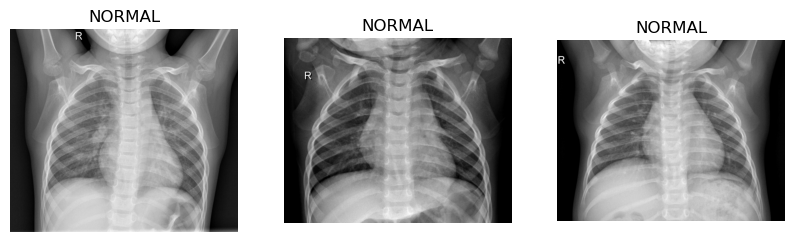

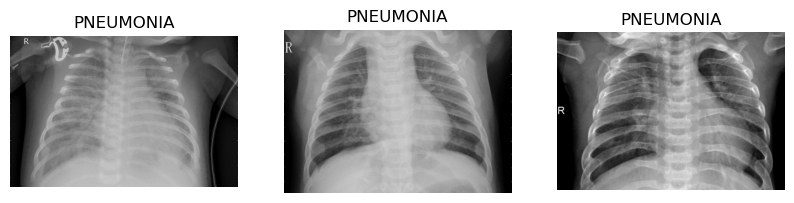

In [4]:
def plot_images(category, dataset_type, num_images=3):
    path = os.path.join(data_path, dataset_type, category)
    images = os.listdir(path)[:num_images]
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(path, img_name))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category}")
        plt.axis('off')
    plt.show()

plot_images("NORMAL", "train")
plot_images("PNEUMONIA", "train")

**High-intensity abnormal areas**: In the MRI of a patient with pneumonia, there are areas that appear brighter (due to inflammation or fluid) compared to the image of a normal patient, where the lungs appear dark.

**Consolidations and opacities**: Pulmonary consolidation areas, which are regions where the alveoli are filled with fluid and inflammatory cells, are not present in a healthy patient.

**Changes in lung structure**: The appearance of pulmonary edema and thickening of the bronchi and pleura is a typical indicator of infection in MRI images 
of a patient with pneumonia.

**Pleural effusion**: If the infection is severe, a pleural effusion (accumulation of fluid between the two layers of the pleura) may be observed, which is not normal.

In [5]:
def load_images_from_path(path, grayscale=True):
    """
    Charge les images présentes dans un répertoire donné et les stocke dans une liste.
    
    Parameters:
        path (str): Le chemin du répertoire contenant les images.
        grayscale (bool): Si True, charge les images en niveaux de gris.
        
    Returns:
        list: Une liste contenant toutes les images chargées et redimensionnées.
    """
    images = []
    
    if not os.path.exists(path):
        raise FileNotFoundError(f"The specified path '{path}' does not exist.")
    
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        
        if os.path.isfile(file_path):
            if grayscale:
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if image is not None:
                images.append(image)
    return images

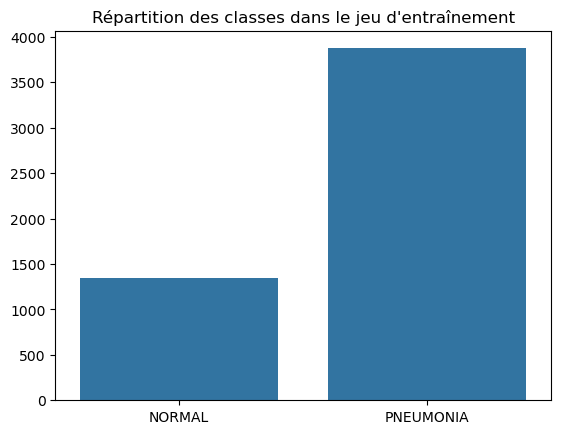

In [6]:
train_counts = {'NORMAL': len(os.listdir(os.path.join(train_path, 'NORMAL'))),
                'PNEUMONIA': len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))}

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Répartition des classes dans le jeu d'entraînement")
plt.show()


We can observe that the class distribution is not balanced, which could potentially impact the performance of the machine learning model. Therefore, we will proceed to resample the dataset to address this imbalance in the next sections of this notebook.

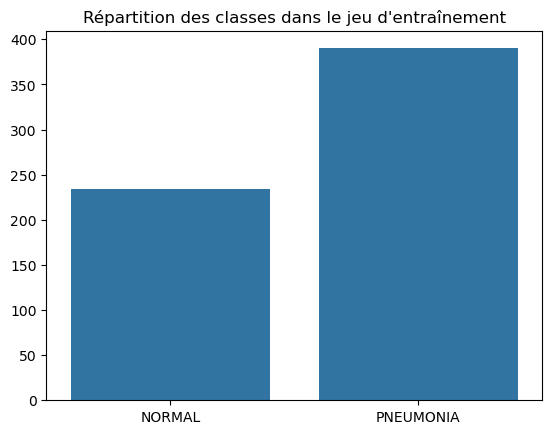

In [7]:
train_counts = {'NORMAL': len(os.listdir(os.path.join(test_path, 'NORMAL'))),
                'PNEUMONIA': len(os.listdir(os.path.join(test_path, 'PNEUMONIA')))}

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Répartition des classes dans le jeu d'entraînement")
plt.show()


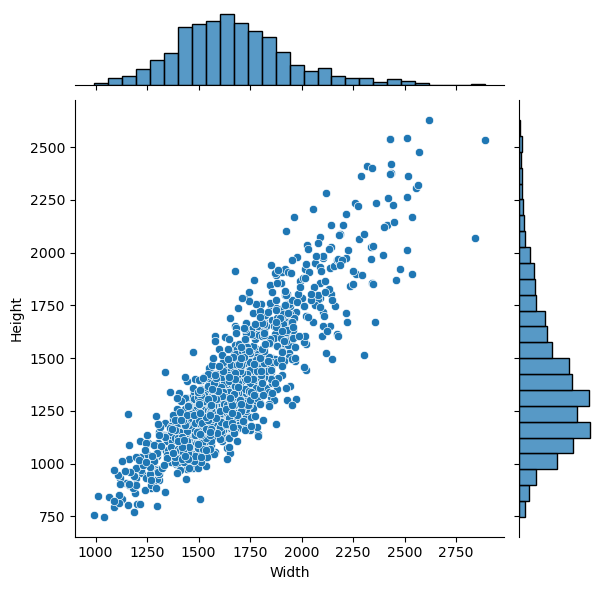

In [8]:
image_shapes = []

#for category in ["NORMAL", "PNEUMONIA"]:
path = os.path.join(train_path, "NORMAL")
for img_name in os.listdir(path)[:1000]:  
    img = Image.open(os.path.join(path, img_name))
    image_shapes.append(img.size)

df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
sns.jointplot(x="Width", y="Height", data=df_shapes, kind="scatter")
plt.show()

The graph above reveals variations in the dimensions of the images within the dataset. Standardizing the image dimensions is essential before proceeding with the training phase.

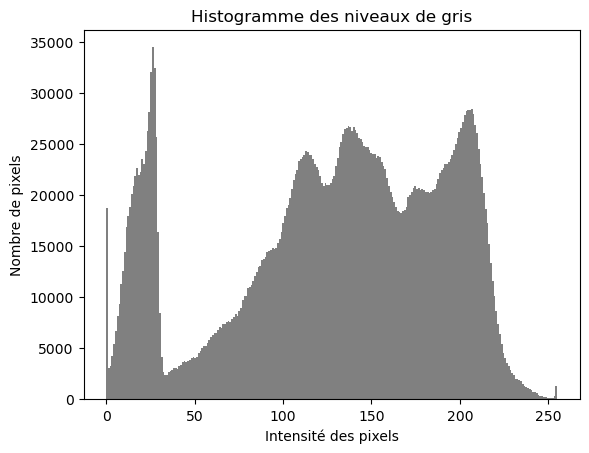

In [9]:
def plot_histogram(img_path):
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)
    plt.hist(img_array.ravel(), bins=256, color='gray')
    plt.title("Histogramme des niveaux de gris")
    plt.xlabel("Intensité des pixels")
    plt.ylabel("Nombre de pixels")
    plt.show()

plot_histogram(os.path.join(train_path, "NORMAL", os.listdir(os.path.join(train_path, "NORMAL"))[0]))

The histogram represents the distribution of grayscale levels in an image. The horizontal axis represents pixel intensity (0 = black, 255 = white).The vertical axis indicates the number of pixels for each intensity level.
It is importnat to note that a significant peak in the darker tones (low pixels intensity) may indicate low contrast or a lighting issue in the image.

## Data Preparation

### Data Standardization

#### 1-Naive Standardization

The objectif is to prepare chest X-ray images for analysis by ensuring they all have the same dimensions (256x256 pixels). This standardization is essential for consistent input to machine learning models or image processing tasks.

In [10]:
# Loading images
images_train_normal = load_images_from_path(train_path_normal)
images_train_pneumonia = load_images_from_path(train_path_pneumonia) 

In [12]:
# Standardizing image dimensions 
standard_size = (256, 256)  # Dimensions cibles (largeur, hauteur)
images_train_normal_resized = [cv2.resize(image, standard_size) for image in images_train_normal] 
images_train_pneumonia_resized = [cv2.resize(image, standard_size) for image in images_train_pneumonia]
print(len(images_train_normal_resized), len(images_train_pneumonia_resized))

1341 3875


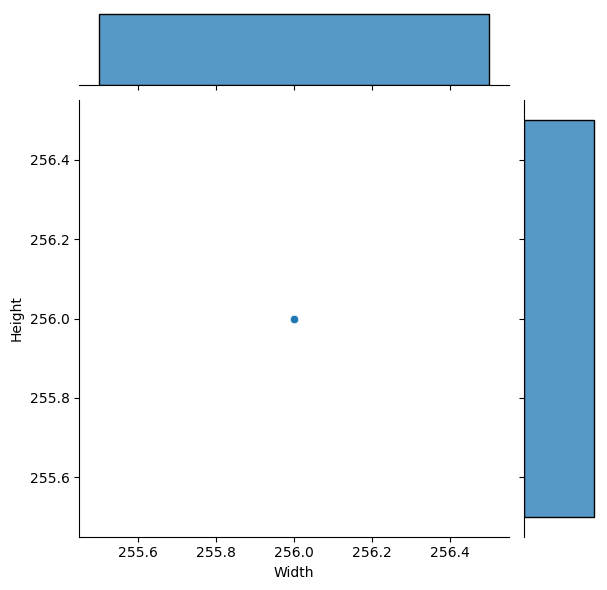

In [26]:
image_shapes = []

for img_name in images_train_normal_resized[:100]:  
    height, width = img_name.shape[:2] 
    image_shapes.append([width, height])

df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
sns.jointplot(x="Width", y="Height", data=df_shapes, kind="scatter")
plt.show()

Standardizing image resolutions to a fixed size, like 256×256 is common in image processing and machine learning because it simplifies model input requirements. However, resizing can indeed lead to undesirable effects, such as:

**Blurriness**: When images are upscaled significantly, the interpolation can introduce blurring.

**Loss of Detail**: Downscaling may remove important features in the image, which can negatively impact model performance.

**Aspect Ratio Distortion**: If the original aspect ratio isn't preserved during resizing, it can distort the content of the image.

Solution --> Preserving Aspect Ratio.

Instead of forcing all images to 256×256 pixels, resize them so that the shorter side matches 256 while maintaining the aspect ratio. Then, pad the remaining space with black (zero) pixels to make the final dimensions 256×256.

#### 2-Resizing to 1024x1024 resolution while keeping aspect ratio

In [30]:
def resize_with_padding(image, target_size):
    """
    Resize an image while preserving its aspect ratio and pad the remaining space with black pixels.
    
    Parameters:
        image (numpy array): The input image to resize.
        target_size (int): The desired size for both width and height of the output image.
    
    Returns:
        numpy array: The resized and padded image.
    """
    h, w = image.shape[:2]
    scale = target_size / max(h, w)  # Scale factor to resize while preserving aspect ratio
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize the image
    resized = cv2.resize(image, (new_w, new_h))
    
    # Calculate padding
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2
    
    # Add padding to make the image square
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

# Standardizing image dimensions with padding
target_size = 1024  # Desired size (width and height)

images_train_normal_resized_1024 = [resize_with_padding(image, target_size) for image in images_train_normal]
images_train_pneumonia_resized_1024 = [resize_with_padding(image, target_size) for image in images_train_pneumonia]

print(len(images_train_normal_resized_1024), len(images_train_pneumonia_resized_1024))


1341 3875


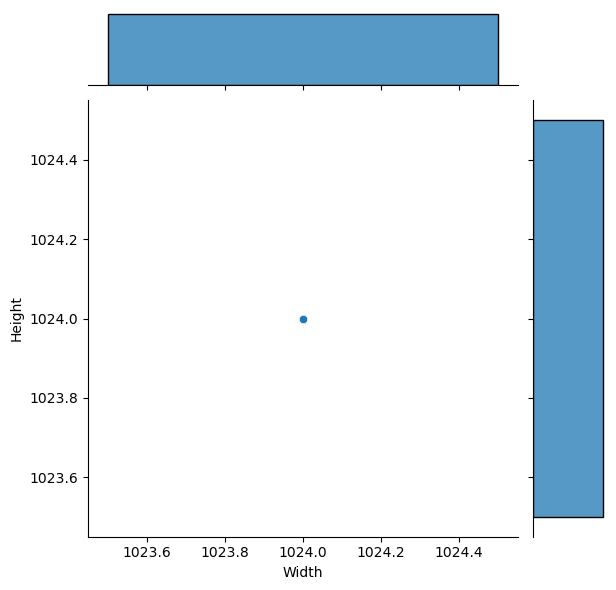

In [25]:
image_shapes = []
for img_name in images_train_pneumonia_resized_1024[:100]:  
    height, width = img_name.shape[:2] 
    image_shapes.append([width, height])

df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
sns.jointplot(x="Width", y="Height", data=df_shapes, kind="scatter")
plt.show()

Now we are sure that the images have the same dimension. It is important to make sure that all  images have the same resolution.

#### 3-Resizing to 512x512 resolution while keeping aspect ratio

In [27]:
def resize_with_padding(image, target_size):
    """
    Resize an image while preserving its aspect ratio and pad the remaining space with black pixels.
    
    Parameters:
        image (numpy array): The input image to resize.
        target_size (int): The desired size for both width and height of the output image.
    
    Returns:
        numpy array: The resized and padded image.
    """
    h, w = image.shape[:2]
    scale = target_size / max(h, w)  # Scale factor to resize while preserving aspect ratio
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize the image
    resized = cv2.resize(image, (new_w, new_h))
    
    # Calculate padding
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2
    
    # Add padding to make the image square
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

# Standardizing image dimensions with padding
target_size = 512  # Desired size (width and height)

images_train_normal_resized_512 = [resize_with_padding(image, target_size) for image in images_train_normal]
images_train_pneumonia_resized_512 = [resize_with_padding(image, target_size) for image in images_train_pneumonia]

print(len(images_train_normal_resized_512), len(images_train_pneumonia_resized_512))


1341 3875


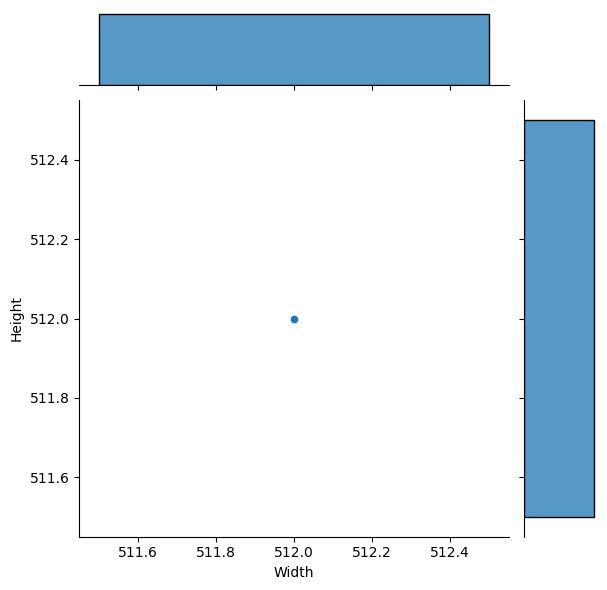

In [28]:
image_shapes = []
for img_name in images_train_pneumonia_resized_512[:100]:  
    height, width = img_name.shape[:2] 
    image_shapes.append([width, height])

df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
sns.jointplot(x="Width", y="Height", data=df_shapes, kind="scatter")
plt.show()

### Data Resampling


To address the class imbalance observed in the training and validation datasets, where pneumonia cases are overrepresented, it is important to choose between undersampling (reducing pneumonia images) and oversampling (increasing normal images). To avoid information loss that could negatively impact the machine learning model's performance, oversampling is the preferred approach in this case. This can be achieved by duplicating images from the normal class or applying data augmentation techniques

In [ ]:
normal_images = images_train_normal_resized_512
pneumonia_images = images_train_pneumonia_resized_512

# Step 1: Calculate the difference in class sizes
normal_count = len(normal_images)
pneumonia_count = len(pneumonia_images)

# Step 2: Oversample the normal images to match pneumonia images
if normal_count < pneumonia_count:
    oversampled_normal_images = normal_images.copy()
    
    while len(oversampled_normal_images) < pneumonia_count:
        oversampled_normal_images.append(random.choice(normal_images))
else:
    oversampled_normal_images = normal_images

# Step 3: Combine the balanced datasets
balanced_images = oversampled_normal_images + pneumonia_images
balanced_labels = [0] * len(oversampled_normal_images) + [1] * len(pneumonia_images)  # Assuming 0 = Normal, 1 = Pneumonia

# Shuffle the dataset to mix the classes
combined = list(zip(balanced_images, balanced_labels))
random.shuffle(combined)
balanced_images, balanced_labels = zip(*combined)

# Convert to numpy arrays for training, potenially needed for training
balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)

print(f"Balanced dataset size: {len(balanced_images)} (Normal: {len(oversampled_normal_images)}, Pneumonia: {len(pneumonia_images)})")


Bypass the RAM issue by attempting to store the images in a PyTorch DataLoader. If it still persist we will have to load the images in the internal storage of the laptop.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Conversion des images en tenseurs
balanced_images_tensor = torch.tensor(balanced_images, dtype=torch.uint8)
balanced_labels_tensor = torch.tensor(balanced_labels, dtype=torch.long)

# Création du DataLoader
dataset = TensorDataset(balanced_images_tensor, balanced_labels_tensor)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

for batch_images, batch_labels in dataloader:
    # Traitement des lots
    pass


## Modelisation 